In [110]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

import torch
from torcheeg.models import EEGNet
from torcheeg.models import DGCNN
from torcheeg import transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from matplotlib import cm
import matplotlib.colors as colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [112]:
import sys 
sys.path.append("/home/aurelien.stumpf/Development/BCI_Classification/")
from eeg_project_package import dataset, models, spectral_analysis, training

In [151]:
import importlib
importlib.reload(dataset)
importlib.reload(training)
importlib.reload(models)
importlib.reload(spectral_analysis)

<module 'eeg_project_package.spectral_analysis' from '/home/aurelien.stumpf/Development/BCI_Classification/eeg_project_package/spectral_analysis.py'>

## Check Loading of Physio Dataset Files

Number of channels:  64
Number of samples:  64


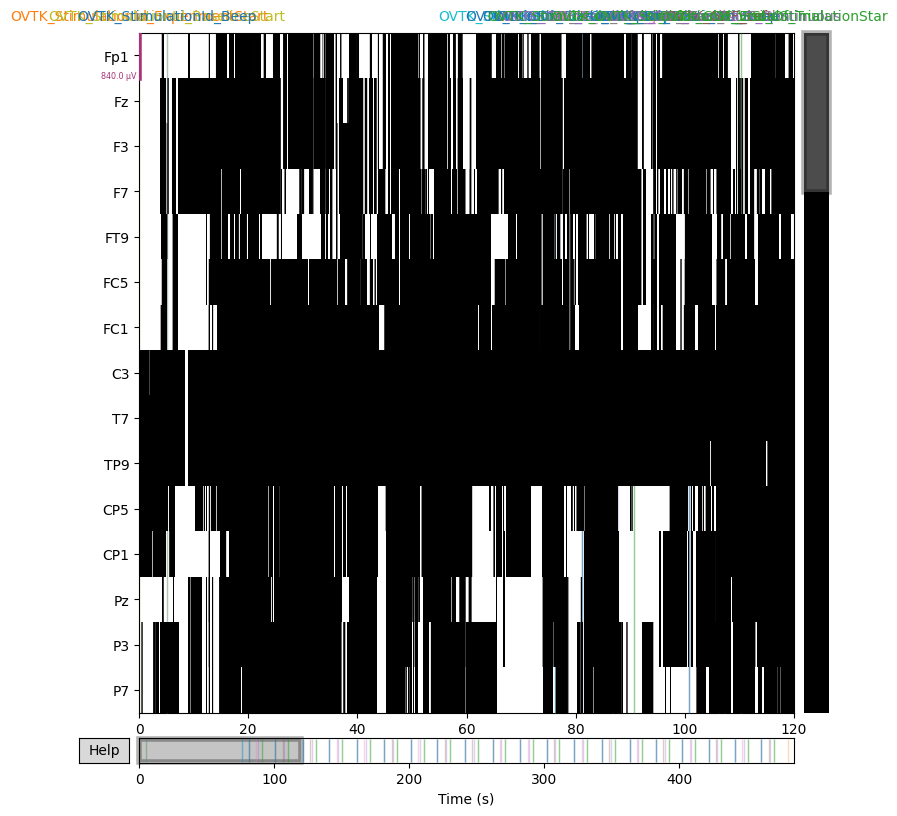

In [6]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.46.29].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

# list of all channel names
list_all_ch_names = raw_obj.ch_names

# Signal Analysis

In [74]:
num_subject = 6
num_session = 2

if num_subject < 10:
    subject_number = "0" + str(num_subject)
else:
    subject_number = str(num_subject)

session_number = "0" + str(num_session)

print("Subject: ", subject_number, " Session: ", session_number)

# Define the path to the data
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-{}/ses-{}/EEG/".format(subject_number, session_number)

# List all the files in the folder
files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]
list_train_files = files[0:-2]
list_test_files = files[-2:]
print("Train files: ", list_train_files)

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_name_channels = ["CP1","CP3","CP2","CP4","CP6","CPz","C1","C3","C2","C4","C6","Cz","CPz"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

# Define the labels
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

dict_ = {"type_psd":"burg","tmin":0,"tmax":4,"fs":500,"nfft":400,"noverlap":100,"nperseg":400,"filter_order":100,"fmin":4,"fmax":30}

trainset = dataset.EEG_Dataset(files_list = list_train_files, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = "time", dict_ = dict_)
testset = dataset.EEG_Dataset(files_list = list_test_files, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = "time", dict_ = dict_)



Subject:  06  Session:  02
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-15.48.23].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.41.18].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.30.24].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.09.32].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Train-[2022.05.10-15.00.59].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-15.58.59].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Train-[2022.05.10-15.10.09].edf']
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.09.32].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationI

In [75]:
# Detrend
signal = trainset.features[:,0,:,:]
time = np.arange(np.shape(trainset.features)[-1])

for k in range(signal.shape[0]):
    for l in range(signal.shape[1]):
        values = signal[k,l,:]
        # Fitting a polynomial of degree 1 and 13
        coefficients = np.polyfit(time, values, 5)
        poly_function = np.poly1d(coefficients)
        predicted_values = poly_function(time)
        signal[k,l,:] = values - predicted_values

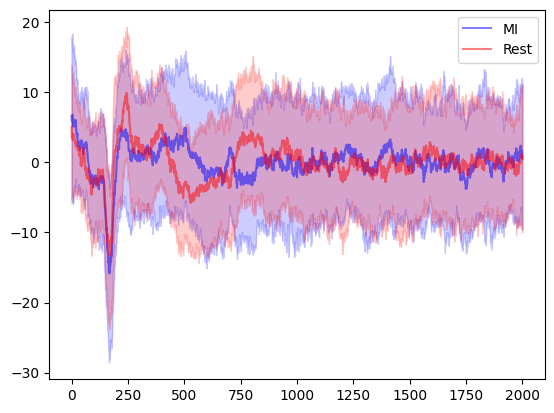

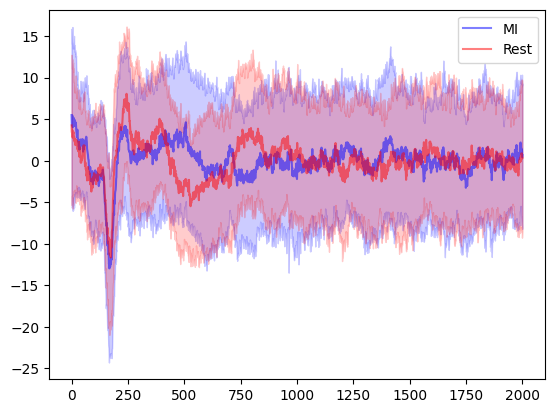

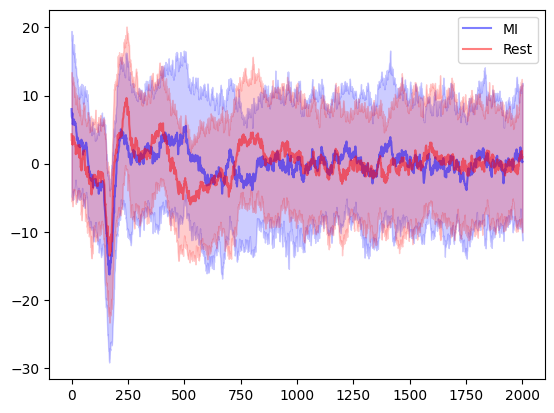

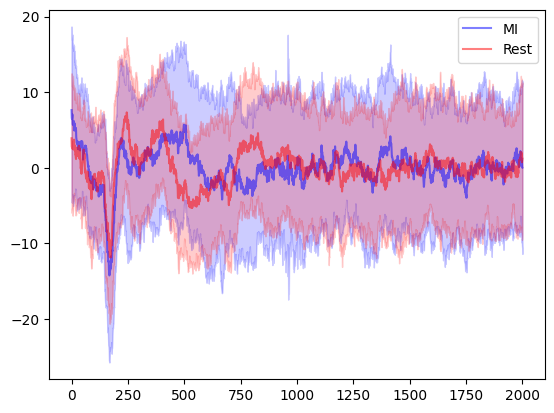

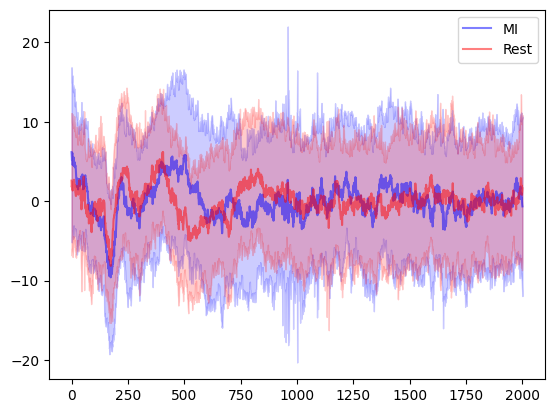

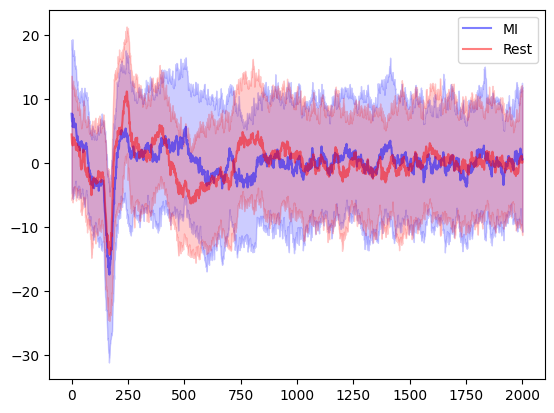

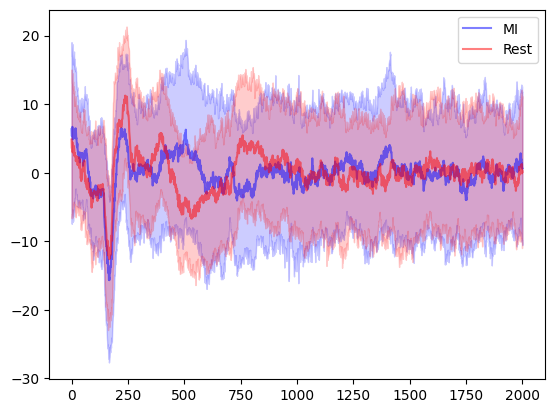

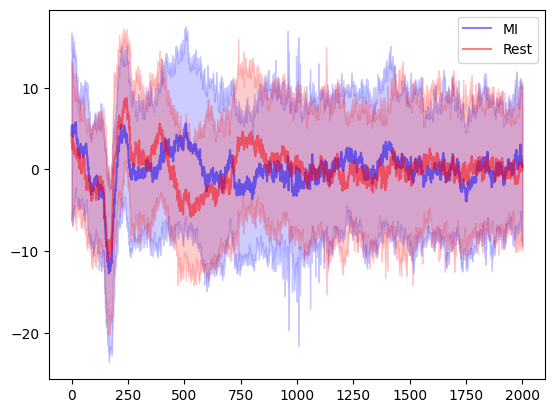

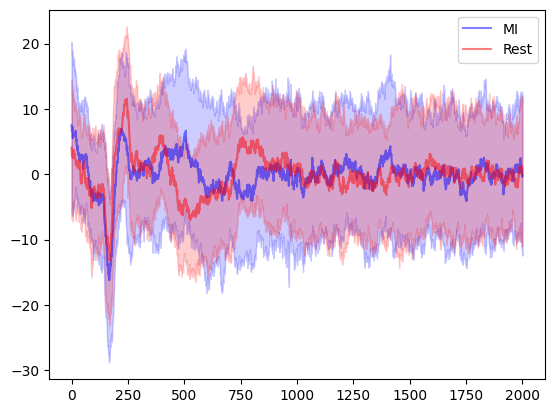

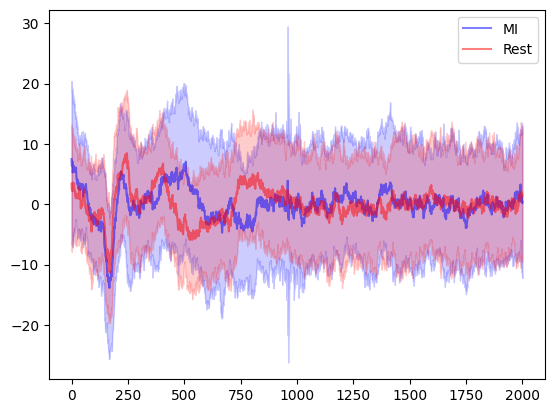

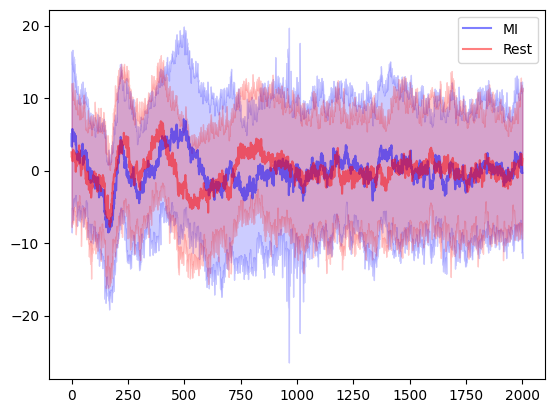

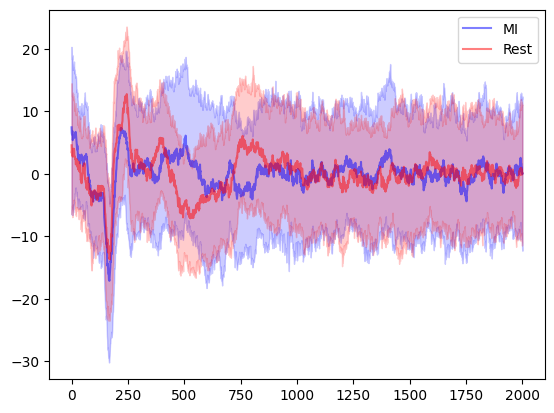

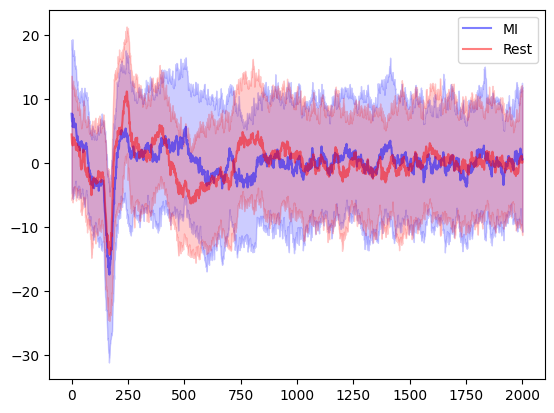

In [76]:
# Average all signals with same label
signal_average_mi = torch.mean(signal[trainset.labels == 1,:,:], axis = 0)
signal_std_mi = torch.std(signal[trainset.labels == 1,:,:], axis = 0)
signal_average_rest = torch.mean(signal[trainset.labels == 0,:,:], axis = 0)
signal_std_rest = torch.std(signal[trainset.labels == 0,:,:], axis = 0)

# Plot the average signals
for i in range(signal_average_mi.shape[0]):
    plt.plot(signal_average_mi[i,:], 'b', alpha=0.5, label='MI')
    plt.fill_between(np.arange(signal_average_mi.shape[1]), signal_average_mi[i,:]-signal_std_mi[i,:], signal_average_mi[i,:]+signal_std_mi[i,:], color='b', alpha=0.2)
    plt.plot(signal_average_rest[i,:], 'r', alpha=0.5, label='Rest')
    plt.fill_between(np.arange(signal_average_rest.shape[1]), signal_average_rest[i,:]-signal_std_rest[i,:], signal_average_rest[i,:]+signal_std_rest[i,:], color='r', alpha=0.2)
    plt.legend()
    plt.show()

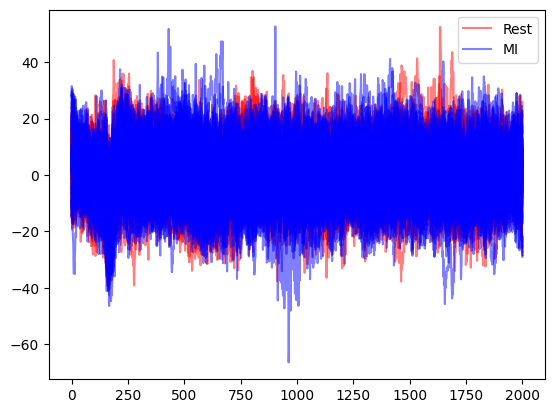

In [77]:
# Plot the signals for a given channel
signal_mi = signal[trainset.labels == 1,:,:]
signal_rest = signal[trainset.labels == 0,:,:]
channel = 0
for i in range(signal_rest.shape[0]):
    if i == 0:
        plt.plot(signal_rest[i,channel,:], 'r', alpha=0.5, label = 'Rest')
    else:
        plt.plot(signal_rest[i,channel,:], 'r', alpha=0.5)
for i in range(signal_mi.shape[0]):
    if i == 0:
        plt.plot(signal_mi[i,channel,:], 'b', alpha=0.5, label='MI')
    else:
        plt.plot(signal_mi[i,channel,:], 'b', alpha=0.5)
plt.legend()
plt.show()


# Desynchronization

Subject:  01  Session:  03
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-17.11.28].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-17.22.38].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.35.28].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Train-[2022.04.11-15.58.09].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.44.17].edf']
/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-17.11.28].edf


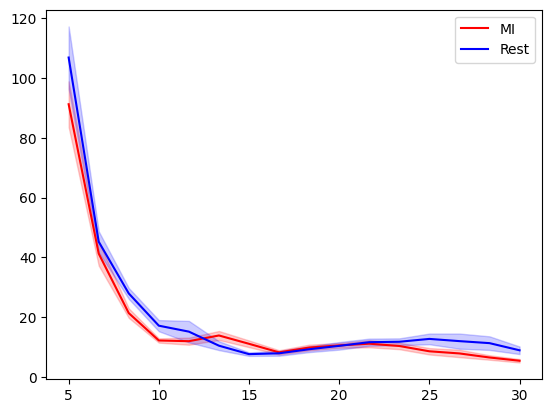

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-17.22.38].edf


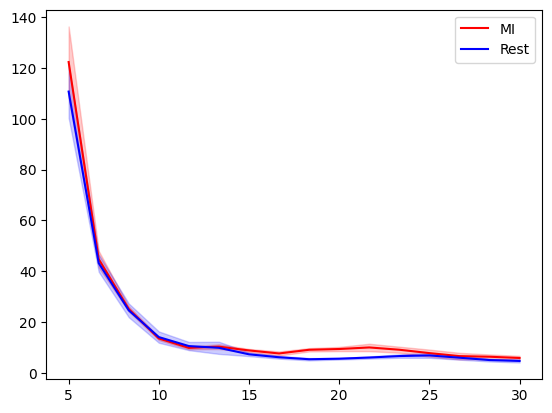

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.35.28].edf


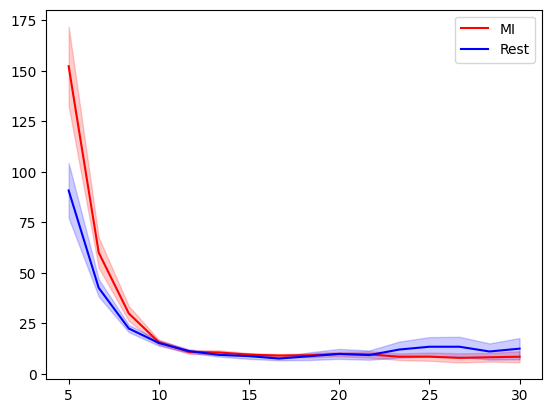

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Train-[2022.04.11-15.58.09].edf


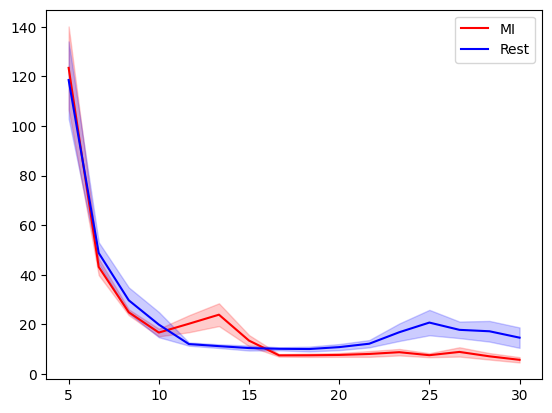

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.44.17].edf


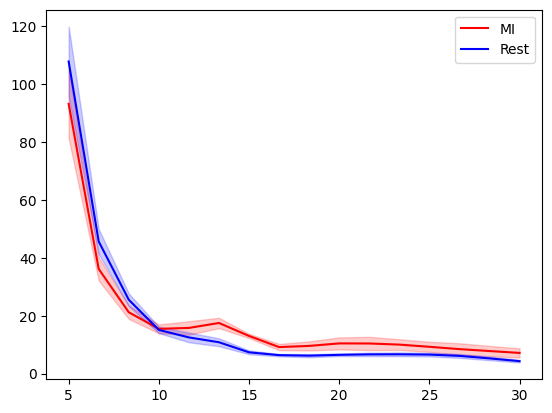

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Train-[2022.04.11-16.16.13].edf


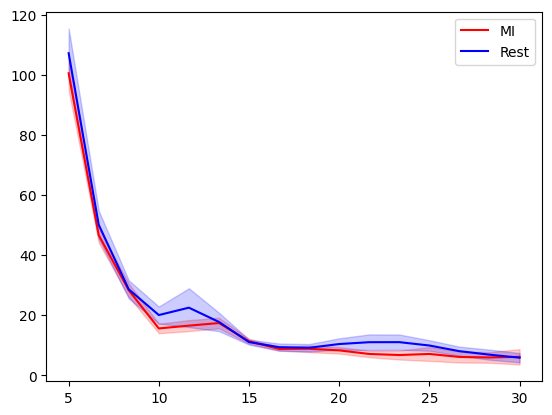

/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-03/EEG/Test-[2022.04.11-16.52.39].edf


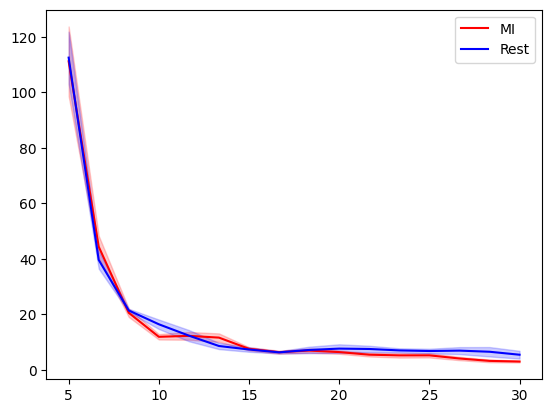

In [165]:
num_subject = 1
num_session = 3

detrend = False

if num_subject < 10:
    subject_number = "0" + str(num_subject)
else:
    subject_number = str(num_subject)

session_number = "0" + str(num_session)

print("Subject: ", subject_number, " Session: ", session_number)

# Define the path to the data
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-{}/ses-{}/EEG/".format(subject_number, session_number)

# List all the files in the folder
files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]
list_train_files = files[0:-2]
list_test_files = files[-2:]
print("Train files: ", list_train_files)

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

# Define the labels
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

dict_ = {"polynomial_degree":10,"type_psd":"welch","tmin":0,"tmax":4,"fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}

for file in files :
    print(file)
    list_file = [file]
    
    try : 
        data = dataset.EEG_Dataset(files_list = list_file, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = "psd", dict_ = dict_)
        colors = ['r','b']
        signal = data.features
        list_freqs = data.freqs
        list_labels = data.labels
        # Plot the PSD with variance
        if signal.shape[0] == 0:
            continue
        else:
            label_rest = np.argwhere(list_labels == 0)
            signal = np.sum(signal, axis = 1)
            signal_rest = np.mean(signal[label_rest,:],axis = 0).reshape(-1)
            signal_rest_std_dev = np.std(signal[label_rest,:],axis = 0).reshape(-1) / np.sqrt(len(label_rest))
            plt.plot(list_freqs,signal_rest, color='r', label = "MI")
            plt.fill_between(list_freqs, signal_rest-signal_rest_std_dev, signal_rest+signal_rest_std_dev, color='r', alpha=0.2)

            label_mi = np.argwhere(list_labels == 1)
            signal_mi = np.mean(signal[label_mi,:],axis = 0).reshape(-1)
            signal_mi_std_dev = np.std(signal[label_mi,:],axis = 0).reshape(-1) / np.sqrt(len(label_mi))
            plt.plot(list_freqs,signal_mi, color='b', label = "Rest")
            plt.fill_between(list_freqs, signal_mi-signal_mi_std_dev, signal_mi+signal_mi_std_dev, color='b', alpha=0.2)

            plt.legend()
            plt.show()
            
    except:
        print("Error")
        continue
    

In [164]:
trainset = dataset.EEG_Dataset(files_list = list_train_files, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = "psd", dict_ = dict_)
testset = dataset.EEG_Dataset(files_list = list_test_files, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = "psd", dict_ = dict_)

X_train = trainset.features[:,:,:].reshape(trainset.features.shape[0], -1)
y_train = trainset.labels
X_test = testset.features[:,:,:].reshape(testset.features.shape[0], -1)
y_test = testset.labels

# Train LDA classifier
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred = lda_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("LDA accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("SVM accuracy: ", acc)

# Train SVM classifier
svm_clf = SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
acc = np.mean(y_pred == y_test)
print("rbf SVM accuracy: ", acc)

LDA accuracy:  0.7
SVM accuracy:  0.725
rbf SVM accuracy:  0.825


In [161]:
lda_accuracies = []
linear_svm_accuracies = []
rbf_svm_accuracies = []

for num_subject in [1,2,3,5,6,7,8,10,11,13,14]:

    for num_session in [1,2,3]:

        if num_subject < 10:
            subject_number = "0" + str(num_subject)
        else:
            subject_number = str(num_subject)

        session_number = "0" + str(num_session)

        print("Subject: ", subject_number, " Session: ", session_number)

        # Define the path to the data
        folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-{}/ses-{}/EEG/".format(subject_number, session_number)

        # List all the files in the folder
        files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]
        list_train_files = files[0:-2]
        list_test_files = files[-2:]
        print("Train files: ", list_train_files)

        # Define the labels
        list_labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

        # Define the channels
        list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
        ch_names = raw_obj.info['ch_names']
        list_idx_channels = [ch_names.index(name) for name in list_name_channels]

        dict_ = {"polynomial_degree":10,"type_psd":"burg","tmin":0,"tmax":4,"fs":500,"nfft":300,"noverlap":150,"nperseg":300,"filter_order":19,"fmin":4,"fmax":30}
        trainset = dataset.EEG_Dataset(files_list = list_train_files, list_idx_channels = list_idx_channels, list_labels = list_labels, feature_type = "psd", dict_ = dict_)
        testset = dataset.EEG_Dataset(files_list = list_test_files, list_idx_channels = list_idx_channels, list_labels = list_labels, feature_type = "psd", dict_ = dict_)

        X_train = trainset.features[:,:,:].reshape(trainset.features.shape[0], -1)
        y_train = trainset.labels
        X_test = testset.features[:,:,:].reshape(testset.features.shape[0], -1)
        y_test = testset.labels

        # Train LDA classifier
        lda_clf = LinearDiscriminantAnalysis()
        lda_clf.fit(X_train, y_train)
        y_pred = lda_clf.predict(X_test)
        acc = np.mean(y_pred == y_test)
        print("LDA accuracy: ", acc)
        lda_accuracies.append(acc)

        # Train Linear SVM classifier
        svm_clf = SVC(kernel='linear')
        svm_clf.fit(X_train, y_train)
        y_pred = svm_clf.predict(X_test)
        acc = np.mean(y_pred == y_test)
        print("Linear SVM accuracy: ", acc)
        linear_svm_accuracies.append(acc)

        # Train Gaussian SVM classifier
        svm_clf = SVC(kernel='rbf')
        svm_clf.fit(X_train, y_train)
        y_pred = svm_clf.predict(X_test)
        acc = np.mean(y_pred == y_test)
        print("Gaussian SVM accuracy: ", acc)
        rbf_svm_accuracies.append(acc)

Subject:  01  Session:  01
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Train-[2022.03.28-17.08.38].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Train-[2022.03.28-16.58.43].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-18.23.31].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.36.22].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-18.14.13].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-01/EEG/Test-[2022.03.28-17.56.08].edf']
LDA accuracy:  0.8
Linear SVM accuracy:  0.775
Gaussian SVM accuracy:  0.75
Subject:  01  Session:  02
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.34.19].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-01/ses-02/EEG/Train-[2022.04.04-16.15.17].edf', '/ne

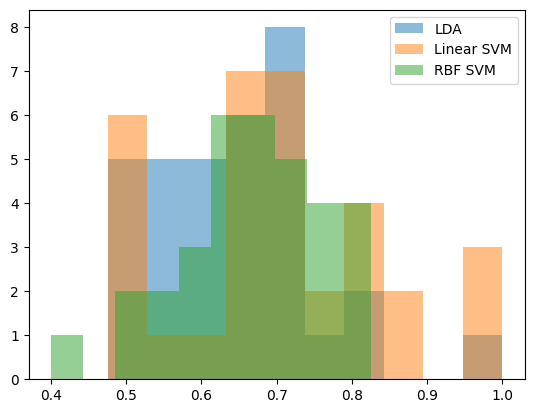

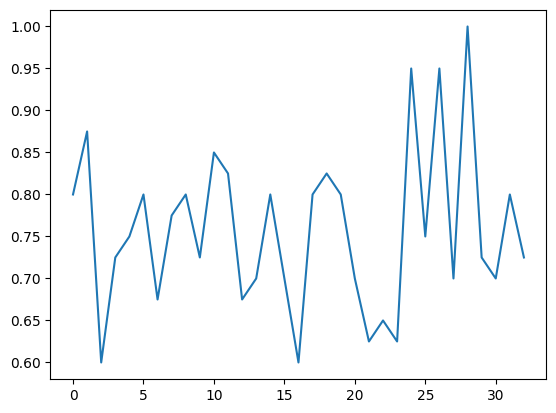

In [162]:
lda_accuracies = np.array(lda_accuracies)
linear_svm_accuracies = np.array(linear_svm_accuracies)
rbf_svm_accuracies = np.array(rbf_svm_accuracies)

plt.hist(lda_accuracies, bins=10, alpha=0.5, label="LDA")
plt.hist(linear_svm_accuracies, bins=10, alpha=0.5, label="Linear SVM")
plt.hist(rbf_svm_accuracies, bins=10, alpha=0.5, label="RBF SVM")
plt.legend()
plt.show()

li_accuracies = np.concatenate([lda_accuracies.reshape(-1,1), linear_svm_accuracies.reshape(-1,1), rbf_svm_accuracies.reshape(-1,1)], axis=1)
plt.plot(np.max(li_accuracies,axis=1), '-')
plt.show()

## Test

In [106]:
num_subject = 6
num_session = 2

if num_subject < 10:
    subject_number = "0" + str(num_subject)
else:
    subject_number = str(num_subject)

session_number = "0" + str(num_session)

print("Subject: ", subject_number, " Session: ", session_number)

# Define the path to the data
folder_path = "/network/lustre/iss02/aramis/projects/cracknetworks/sub-{}/ses-{}/EEG/".format(subject_number, session_number)

# List all the files in the folder
files = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.edf') and not(f.startswith("._"))]
list_train_files = files[0:-2]
list_test_files = files[-2:]
print("Train files: ", list_train_files)

# Define the channels
list_name_channels = ["CP1","CP3","CP5","C1","C3","C5","C2","CP2","Cz","FCz","C4","CP4"]
list_name_channels = ["CP1","CP3","CP2","CP4","CP6","CPz","C1","C3","C2","C4","C6","Cz","CPz"]
ch_names = raw_obj.info['ch_names']
list_idx_channels = [ch_names.index(name) for name in list_name_channels]

# Define the labels
labels = ['OVTK_GDF_Left', 'OVTK_GDF_Right']

dict_ = {"polynomial_degree":10,"type_psd":"burg","tmin":0,"tmax":4,"fs":500,"nfft":400,"noverlap":100,"nperseg":400,"filter_order":100,"fmin":4,"fmax":30}

trainset = dataset.EEG_Dataset(files_list = list_train_files, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = "psd", dict_ = dict_)
testset = dataset.EEG_Dataset(files_list = list_test_files, list_idx_channels = list_idx_channels, list_labels = labels, feature_type = "psd", dict_ = dict_)

Subject:  06  Session:  02
Train files:  ['/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-15.48.23].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.41.18].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.30.24].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.09.32].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Train-[2022.05.10-15.00.59].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-15.58.59].edf', '/network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Train-[2022.05.10-15.10.09].edf']
Error in file:  /network/lustre/iss02/aramis/projects/cracknetworks/sub-06/ses-02/EEG/Test-[2022.05.10-16.09.32].edf
'Event name "OVTK_GDF_Left" could not be found. The following events are present in the data: OVTK_StimulationI

In [105]:
trainset.features.shape

(120, 13, 5)